## Import Packages

In [175]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
import seaborn as sns
from sklearn.utils import resample
from programming2 import BankDataProcessPipeline
import pickle

## Prepare the Data

In [176]:
bank = pd.read_csv('bank-additional-full.csv', sep=';')
bank.shape

(41188, 21)

## Classification Experiment


In [208]:
SEED = 1234

class BankDataProcessPipeline(object):
    def __init__(self, df, classifier=None, option='normalize'):
        self.seed = SEED
        self.option = option
        self.classifier = classifier
        self.df = df
        self.X = self.df.iloc[:,:20]
        self.df.y = self.df.y.replace('no', 0)
        self.df.y = self.df.y.replace('yes',1)
        self.y = self.df.y
        self.categorical_cols = self.X.columns[self.X.dtypes==object]
        self.numerical_cols = self.X.columns[self.X.dtypes!=object]
        self.integrate_cat_nume()

    def custom_split(self, X, y, train_index, test_index):
        return X.take(train_index).reset_index(drop=True), \
               X.take(test_index).reset_index(drop=True), \
               y.take(train_index).reset_index(drop=True), \
               y.take(test_index).reset_index(drop=True)
    
    def feature_select(self, pickle_path):
        with open(pickle_path, 'rb') as f:
            data = pickle.load(f)
        feature_selected_X = pd.concat([pd.DataFrame(data['categorical'], 
                                columns=['categorical_{}'.format(i) for i in range(data['categorical'].shape[1])]), 
                             pd.DataFrame(data['numerical'], 
                                columns=['numerical_{}'.format(i) for i in range(data['numerical'].shape[1])])], axis=1)
        return feature_selected_X
        
    
    def scale(self, cols, range_=(0,1)):
        min_max_scaler_p = MinMaxScaler(feature_range=range_)
        return min_max_scaler_p.fit_transform(self.X[cols])
    
    def one_hot_categorical(self):
        one_hot_encoded_cat = pd.DataFrame()
        for col in self.categorical_cols:
             one_hot_encoded_cat = pd.concat([one_hot_encoded_cat, pd.get_dummies(self.X[col] ,prefix='{}_is'.format(col))], axis=1)
        return one_hot_encoded_cat
        
    def normalize_numerical(self):
        # normalize numerical
        bank_numericals = self.X[self.numerical_cols]
        p_mask = list(map(lambda x: all(bank_numericals[x]>=0), self.numerical_cols))
        n_mask = list(map(lambda x: all(bank_numericals[x]<0), self.numerical_cols))
        p_n_mask = list(map(lambda x: not(all(bank_numericals[x]>=0) or 
                                          all(bank_numericals[x]<0)), self.numerical_cols))
        p_cols = self.numerical_cols[p_mask]
        n_cols = self.numerical_cols[n_mask]
        p_n_cols = self.numerical_cols[p_n_mask]
        scaled_p = pd.DataFrame(self.scale(p_cols), columns=p_cols)
        scaled_n = pd.DataFrame(self.scale(n_cols, range_=(-1,0)), columns=n_cols)
        scaled_p_n = pd.DataFrame(self.scale(p_n_cols, range_=(-1,1)), columns=p_n_cols)
        scaled_bank_numericals = pd.concat([scaled_p, scaled_n, scaled_p_n], axis=1)
        return scaled_bank_numericals
    
    def integrate_cat_nume(self):
        if self.option == 'normalize':
            self.X = pd.concat([self.one_hot_categorical(), self.normalize_numerical()], axis=1)
        else:
            self.X = pd.concat([self.one_hot_categorical(), self.X[self.numerical_cols]], axis=1)
        
    def check_imbalance(self):
        no_cnt = self.y[self.y==0].shape[0]
        yes_cnt = self.y[self.y==1].shape[0]
        print('There are {} data entries labeled as yes, {} data entries labeled as no.'.format(yes_cnt, no_cnt))
        sns.countplot("y",data=pd.DataFrame(self.y, columns=['y']))
        plt.show()
        
    def fit(self, X_train, y_train):
        self.classifier.fit(X_train, y_train)

    def predict(self, X_test):
        return self.classifier.predict(X_test)
    
    def plot_cm(self, cm, title='Confusion matrix', cmap=plt.cm.Blues):
        sns.heatmap(cm, cmap=cmap, annot=True)
        plt.show()

    def eval_results(self, predicted_y_test, y_test):
        accuracy_s = accuracy_score(y_test, predicted_y_test)
        precision_s = precision_score(y_test, predicted_y_test)
        recall_s = recall_score(y_test, predicted_y_test)
        f1_s = f1_score(y_test, predicted_y_test)
        cm = confusion_matrix(y_test, predicted_y_test)  
        print("Accuracy Score:", accuracy_s)
        print("Precision Score:", precision_s)
        print("Recall Score:", recall_s)
        print("f1 Score:", f1_s)
        print('confusion_matrix is: \n', cm, '\n')
        return accuracy_s, precision_s, recall_s, f1_s, cm
    
    def resample(self, X_train, y_train, fold, option, downratio=1, upratio=1):
        tmp_df = pd.concat([X_train, y_train], axis=1)
        no_idx = tmp_df[tmp_df.y==0].index
        yes_idx = tmp_df[tmp_df.y==1].index
        df_majority = tmp_df.iloc[no_idx,:]
        df_minority = tmp_df.iloc[yes_idx,:]
        majority_cnt = df_majority.shape[0]
        minority_cnt = df_minority.shape[0]
        if option == 'downsample':
            df_majority_downsampled = resample(df_majority, 
                                                 replace=False,    
                                                 n_samples=minority_cnt*downratio,     
                                                 random_state=self.seed)
            df_downsampled = pd.concat([df_majority_downsampled, df_minority], axis=0)
            if fold == 1:
                print('After downsampling, there are {} data entries labeled as yes.\n There are {} data entries labeled as no.'.format(len(df_downsampled[df_downsampled.y==1]), 
                                                                                           len(df_downsampled[df_downsampled.y==0])))
                
                plt.figure(figsize=(5,5))
                sns.countplot("y",data=df_downsampled)
                plt.show()
            return df_downsampled.iloc[:, :-1], df_downsampled.y
        elif option == 'upsample':
            df_minority_upsampled = resample(df_minority, 
                                                 replace=True,    
                                                 n_samples=int(majority_cnt*upratio),     
                                                 random_state=self.seed)
            df_upsampled = pd.concat([df_minority_upsampled, df_majority])
            if fold == 1:
                print('After upsampling, there are {} data entries labeled as yes.\n There are {} data entries labeled as no.'.format(len(df_upsampled[df_upsampled.y==1]), 
                                                                                           len(df_upsampled[df_upsampled.y==0])))
                plt.figure(figsize=(5,5))
                sns.countplot("y",data=df_upsampled)
                plt.show()
            return df_upsampled.iloc[:, :-1], df_upsampled.y
        else:
            return X_train, y_train

    
    def k_fold_cross_val(self, fold, option='noresample', downratio=1, upratio=1, feature_engineered=False, topK=None):
        # initialization
        f = 1
        accuracy = []
        precision = []
        recall=[]
        f1=[]
        
        if feature_engineered:
            X = self.feature_select(pickle_path='feature_selection/feature_k={}.pkl'.format(topK)) 
        else:
            X = self.X
        y = self.y
        skf = StratifiedKFold(n_splits=fold, random_state=1, shuffle= True)

        print('The shape of training set is: ', X.shape, '\n')
        for train_index, test_index in skf.split(X, y):
            X_train, X_test, y_train, y_test = self.custom_split(X, y, train_index, test_index)
            X_train, y_train = self.resample(X_train, pd.DataFrame(y_train, columns=['y']), fold=f, option=option, downratio=downratio, upratio=upratio)
            
            self.fit(X_train, y_train)
            predicted_y_test = self.predict(X_test)
            accuracy_s, precision_s, recall_s, f1_s, cm = self.eval_results(predicted_y_test, y_test)
            
            accuracy.append(accuracy_s)
            precision.append(precision_s)
            recall.append(recall_s)
            f1.append(f1_s)
            self.plot_cm(cm)
            f += 1

        metrics_df = pd.DataFrame(
            {'accuracy': accuracy,
            'precision': precision,
            'recall':recall,
            'f1':f1}
        )
        metrics_df.plot()
        return metrics_df

## Task 1

In this task, you will train a logistic regression classifier on Bank
Marketing Dataset to predict whether a client will subscribe a term deposit.

- There are 10 numerical features and 10 categorical features. Please train
Logistic Regression Model 1 based on normalized numerical features and
one-hot encoded categorical features, and train Logistic Regression
Model 2 based on unnormalized numerical feature and one-hot encoded
categorical feature.

- Please use 5-Fold cross-validation for experiments. (See textbook and
https://en.wikipedia.org/wiki/Cross-validation_(statistics))
Please summarize the definitions and mathematical formulae of confusion matrix,
precision metric, recall metric, f-measure metric, and accuracy metric. Please
compare the performance of Logistic Regression Model 1 and Logistic
Regression Model 2 in terms of these four metrics.

$$\text{ A confusion matrix is a table used to describe the performance of a classifier }$$


![](1.png)

$$precision = \frac{TP}{TP+FP}$$

$$recall = \frac{TP}{TP+FN}$$

$$F \: meaure (F_1 \: score) = \frac{2}{\frac{1}{precision} + \frac{1}{recall}} = \frac{2 TP}{2 TP + FP + FN}$$

$$accuracy = \frac{TP + TN}{TP+TN+FP+FN}$$



In [209]:
classifier = LogisticRegression(random_state=SEED, solver='lbfgs')

### Logistic Regression Model 1 :  normalized numerical features and one-hot encoded categorical features

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The shape of training set is:  (41188, 63) 

Accuracy Score: 0.9037387715464918
Precision Score: 0.623400365630713
Recall Score: 0.36745689655172414
f1 Score: 0.4623728813559322
confusion_matrix is: 
 [[7104  206]
 [ 587  341]] 



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


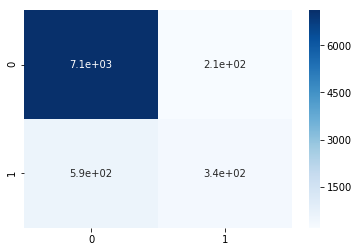

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy Score: 0.9109007040543822
Precision Score: 0.677007299270073
Recall Score: 0.39978448275862066
f1 Score: 0.502710027100271
confusion_matrix is: 
 [[7133  177]
 [ 557  371]] 



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


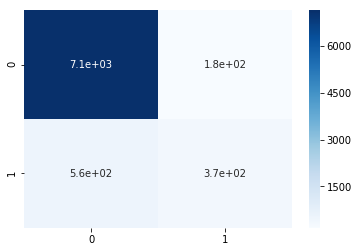

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy Score: 0.9102937606215101
Precision Score: 0.68
Recall Score: 0.38469827586206895
f1 Score: 0.49139710942876796
confusion_matrix is: 
 [[7142  168]
 [ 571  357]] 



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


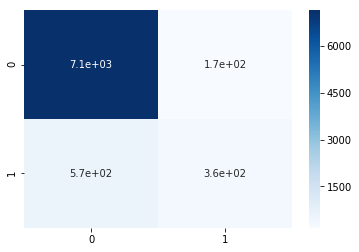

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy Score: 0.9101614665533568
Precision Score: 0.6690647482014388
Recall Score: 0.40086206896551724
f1 Score: 0.5013477088948787
confusion_matrix is: 
 [[7125  184]
 [ 556  372]] 



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


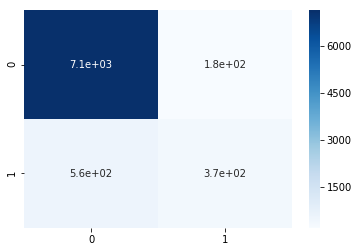

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy Score: 0.9147747966492655
Precision Score: 0.7092592592592593
Recall Score: 0.41271551724137934
f1 Score: 0.5217983651226158
confusion_matrix is: 
 [[7152  157]
 [ 545  383]] 



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


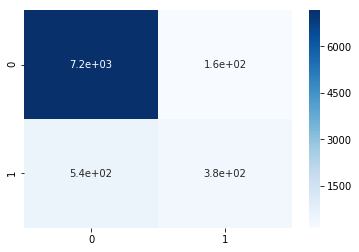

,accuracy,precision,recall,f1
0,0.903739,0.623400,0.367457,0.462373
1,0.910901,0.677007,0.399784,0.502710
2,0.910294,0.680000,0.384698,0.491397
3,0.910161,0.669065,0.400862,0.501348
4,0.914775,0.709259,0.412716,0.521798


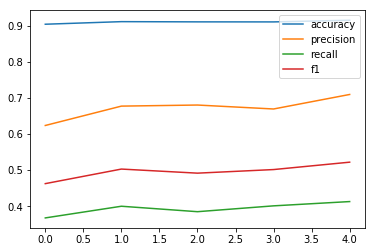

In [211]:
bdpp_logistic = BankDataProcessPipeline(bank, classifier)
bdpp_logistic.k_fold_cross_val(fold=5)

### Logistic Regression Model 2 : unnormalized numerical features and one-hot encoded categorical features

The shape of training set is:  (41188, 63) 



/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy Score: 0.9020393299344501
Precision Score: 0.6126629422718808
Recall Score: 0.3545258620689655
f1 Score: 0.4491467576791809
confusion_matrix is: 
 [[7102  208]
 [ 599  329]] 



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


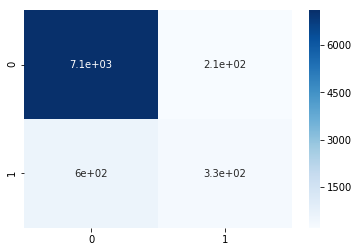

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy Score: 0.9088370963826171
Precision Score: 0.656084656084656
Recall Score: 0.40086206896551724
f1 Score: 0.4976588628762542
confusion_matrix is: 
 [[7115  195]
 [ 556  372]] 



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


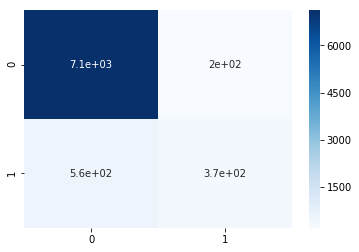

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy Score: 0.9115076474872542
Precision Score: 0.6819012797074955
Recall Score: 0.4019396551724138
f1 Score: 0.5057627118644068
confusion_matrix is: 
 [[7136  174]
 [ 555  373]] 



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


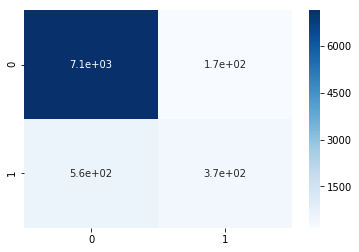

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy Score: 0.9087046254704383
Precision Score: 0.6577060931899642
Recall Score: 0.3954741379310345
f1 Score: 0.49394347240915215
confusion_matrix is: 
 [[7118  191]
 [ 561  367]] 



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


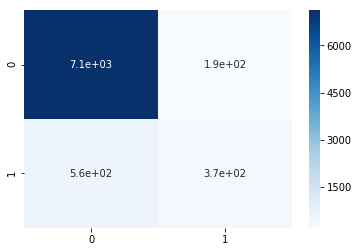

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy Score: 0.9151390069199952
Precision Score: 0.699825479930192
Recall Score: 0.43211206896551724
f1 Score: 0.5343104596935376
confusion_matrix is: 
 [[7137  172]
 [ 527  401]] 



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


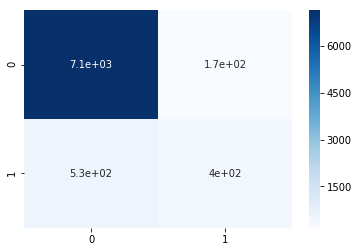

,accuracy,precision,recall,f1
0,0.902039,0.612663,0.354526,0.449147
1,0.908837,0.656085,0.400862,0.497659
2,0.911508,0.681901,0.401940,0.505763
3,0.908705,0.657706,0.395474,0.493943
4,0.915139,0.699825,0.432112,0.534310


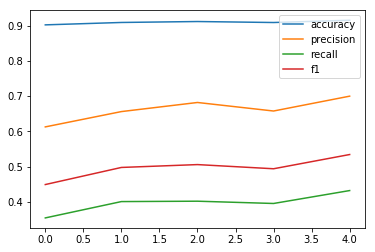

In [212]:
bdpp_logistic = BankDataProcessPipeline(bank, classifier, option='unnormalize')
bdpp_logistic.k_fold_cross_val(fold=5)

By comparing the performance of Logistic Regression Model 1 and 2 with 5-fold cross validation, the results are actually quite similar, model 1 (normalized) is sightly better.

## Task 2
Imbalanced Issue

Note that data imbalance exists in this dataset. 

- Please explain why we
want to avoid imbalance issue in training classifiers? 

- Briefly summarize at least 3
methods deal with data imbalance issue. 

- Generate new datasets by either
downsampling or upsampling and repeat the steps in Task 1 to compare the
performance of generated datasets with the original dataset. 

- Note that you only
need to perform sampling algorithms on training set. Please explain why. 

In [213]:
bdpp_logistic = BankDataProcessPipeline(bank, classifier)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


There are 4640 data entries labeled as yes, 36548 data entries labeled as no.


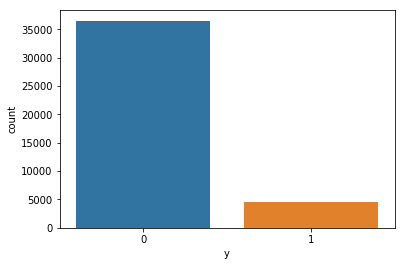

In [214]:
bdpp_logistic.check_imbalance()

- __Please explain why we want to avoid imbalance issue in training classifiers__

For instance, choose one fold from Logistic Regression Model 1, 

- Accuracy Score: 0.9037387715464918
- Precision Score: 0.623400365630713
- Recall Score: 0.36745689655172414
- f1 Score: 0.4623728813559322


- confusion_matrix is: 

\begin{tabular}{ll}
\toprule
7104 & 206 & \\
\midrule
587 &  341 & \\
\bottomrule
\end{tabular}


Here we can see from the confusion matrix that the `False Negative`=587, and `False Positive`=206, which means 206 __no__ classes are classified as __yes__, and 584 __yes__ classes are classified as __no__. Thus the FN value is too high. 

And since the proportion of __no__ classes(__36548/41188__) is way larger than that of __yes__ classes(__4640/41188__), so in the testing dataset, __no__ classes takes up the majority, TN value being too high causes the accuracy score to be misleading and inflated:

$$accuracy = \frac{TP+TN}{TP+TN+FN+FP} = \frac{7104+341}{7104+341+206+587} = 90.4\%$$

Thus we should avoid imbalanced data to prevent the FP and FN value being too high and the inflation of acurracy score.


- __Briefly summarize at least 3 methods deal with data imbalance issue__
    - collect more data for training
    - downsample the majority class in the training data
    - upsample the minority class in the training data
    
- __Note that you only need to perform sampling algorithms on training set. Please explain why__

Because only the training set is used to feed into the predictive model for pattern learning, as long as the classifier is trained as optimal after applying the resampling strategy, whether there exists the imbalance issue in the testing set would not affect the prediction result.

### Downsampling

The shape of training set is:  (41188, 63) 

After downsampling, there are 3712 data entries labeled as yes.
 There are 3712 data entries labeled as no.


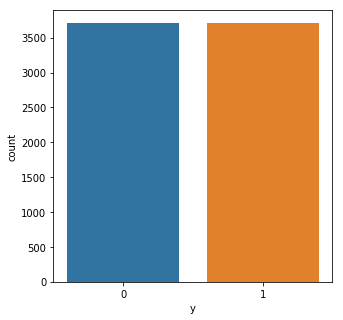

Accuracy Score: 0.8561544064093226
Precision Score: 0.4303523035230352
Recall Score: 0.8556034482758621
f1 Score: 0.572664983772088
confusion_matrix is: 
 [[6259 1051]
 [ 134  794]] 



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


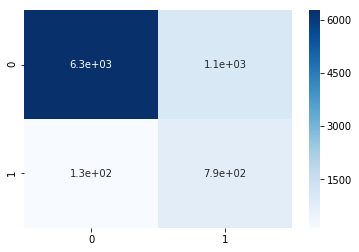

Accuracy Score: 0.8580966253945133
Precision Score: 0.4340448823207444
Recall Score: 0.8545258620689655
f1 Score: 0.5756805807622505
confusion_matrix is: 
 [[6276 1034]
 [ 135  793]] 



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


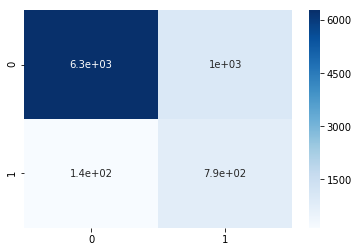

Accuracy Score: 0.8648943918426802
Precision Score: 0.4489795918367347
Recall Score: 0.8771551724137931
f1 Score: 0.5939438161255016
confusion_matrix is: 
 [[6311  999]
 [ 114  814]] 



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


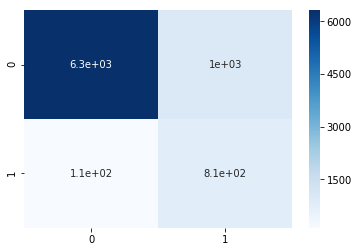

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Accuracy Score: 0.8566225567561006
Precision Score: 0.4312873438348723
Recall Score: 0.8556034482758621
f1 Score: 0.5734922354640665
confusion_matrix is: 
 [[6262 1047]
 [ 134  794]] 



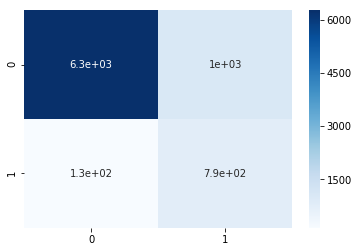

Accuracy Score: 0.8606288697341266
Precision Score: 0.4403470715835141
Recall Score: 0.875
f1 Score: 0.5858585858585859
confusion_matrix is: 
 [[6277 1032]
 [ 116  812]] 



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


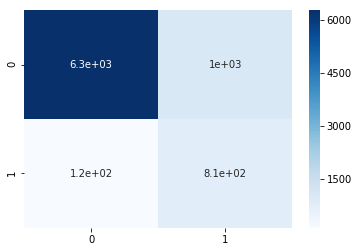

,accuracy,precision,recall,f1
0,0.856154,0.430352,0.855603,0.572665
1,0.858097,0.434045,0.854526,0.575681
2,0.864894,0.448980,0.877155,0.593944
3,0.856623,0.431287,0.855603,0.573492
4,0.860629,0.440347,0.875000,0.585859


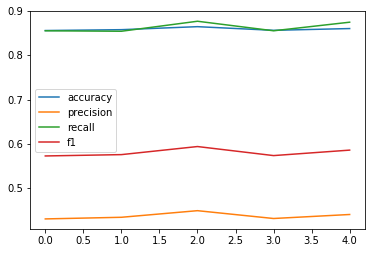

In [215]:
bdpp_logistic.k_fold_cross_val(fold=5, option='downsample')

The shape of training set is:  (41188, 63) 

After downsampling, there are 3712 data entries labeled as yes.
 There are 7424 data entries labeled as no.


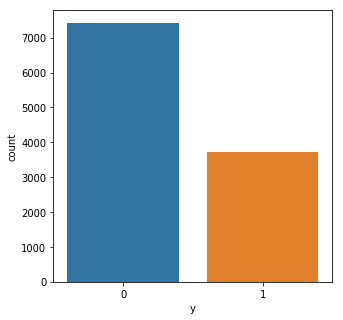

Accuracy Score: 0.8869871327992231
Precision Score: 0.4988929889298893
Recall Score: 0.728448275862069
f1 Score: 0.5922032413491021
confusion_matrix is: 
 [[6631  679]
 [ 252  676]] 



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


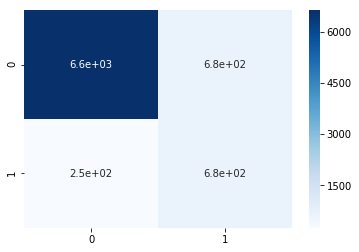

Accuracy Score: 0.8917212915756252
Precision Score: 0.5134128166915052
Recall Score: 0.7424568965517241
f1 Score: 0.6070484581497797
confusion_matrix is: 
 [[6657  653]
 [ 239  689]] 



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


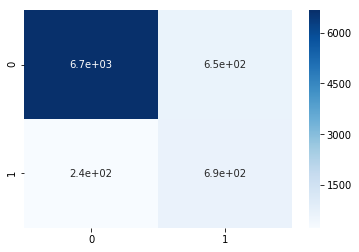

Accuracy Score: 0.8977907259043457
Precision Score: 0.532724505327245
Recall Score: 0.7543103448275862
f1 Score: 0.6244424620874219
confusion_matrix is: 
 [[6696  614]
 [ 228  700]] 



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


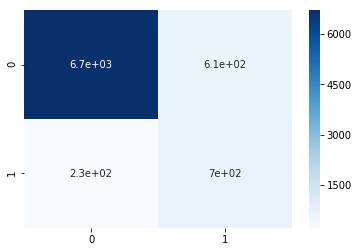

Accuracy Score: 0.8945004249119826
Precision Score: 0.5221971407072987
Recall Score: 0.7478448275862069
f1 Score: 0.614975631369074
confusion_matrix is: 
 [[6674  635]
 [ 234  694]] 



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


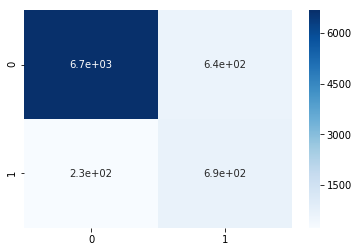

Accuracy Score: 0.8902513050868035
Precision Score: 0.5086455331412104
Recall Score: 0.7607758620689655
f1 Score: 0.6096718480138169
confusion_matrix is: 
 [[6627  682]
 [ 222  706]] 



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


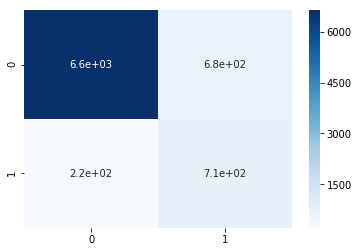

,accuracy,precision,recall,f1
0,0.886987,0.498893,0.728448,0.592203
1,0.891721,0.513413,0.742457,0.607048
2,0.897791,0.532725,0.754310,0.624442
3,0.894500,0.522197,0.747845,0.614976
4,0.890251,0.508646,0.760776,0.609672


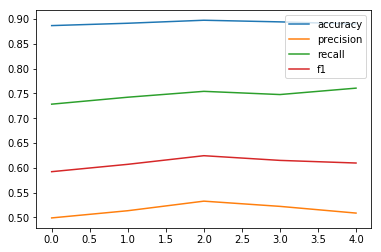

In [216]:
bdpp_logistic.k_fold_cross_val(fold=5, option='downsample', downratio=2)

The shape of training set is:  (41188, 63) 

After downsampling, there are 3712 data entries labeled as yes.
 There are 11136 data entries labeled as no.


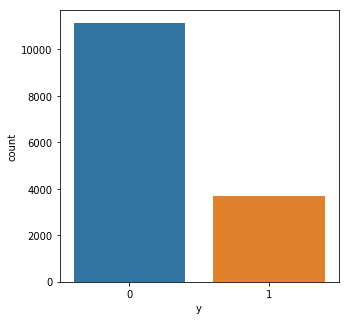

Accuracy Score: 0.8986404467103666
Precision Score: 0.5432558139534883
Recall Score: 0.6293103448275862
f1 Score: 0.5831253120319521
confusion_matrix is: 
 [[6819  491]
 [ 344  584]] 



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


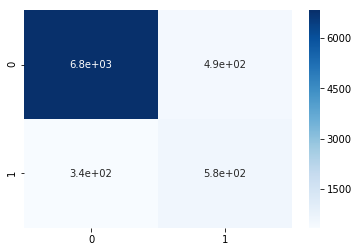

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Accuracy Score: 0.9038601602330663
Precision Score: 0.5641509433962264
Recall Score: 0.6443965517241379
f1 Score: 0.6016096579476861
confusion_matrix is: 
 [[6848  462]
 [ 330  598]] 



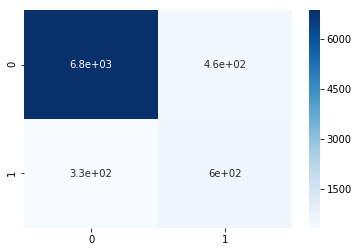

Accuracy Score: 0.9085943190094683
Precision Score: 0.5820056232427366
Recall Score: 0.6691810344827587
f1 Score: 0.6225563909774436
confusion_matrix is: 
 [[6864  446]
 [ 307  621]] 



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


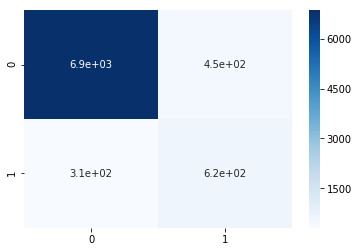

Accuracy Score: 0.9050625227631419
Precision Score: 0.5682242990654206
Recall Score: 0.6551724137931034
f1 Score: 0.6086086086086087
confusion_matrix is: 
 [[6847  462]
 [ 320  608]] 



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


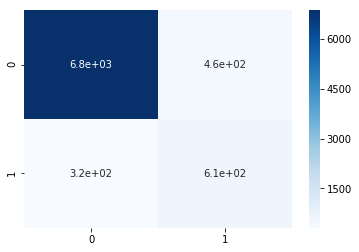

Accuracy Score: 0.9054267330338716
Precision Score: 0.5672990063233966
Recall Score: 0.6767241379310345
f1 Score: 0.6171990171990173
confusion_matrix is: 
 [[6830  479]
 [ 300  628]] 



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


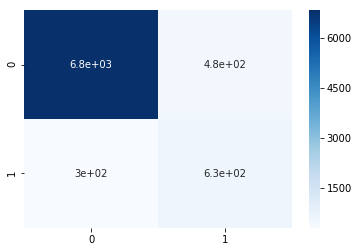

,accuracy,precision,recall,f1
0,0.898640,0.543256,0.629310,0.583125
1,0.903860,0.564151,0.644397,0.601610
2,0.908594,0.582006,0.669181,0.622556
3,0.905063,0.568224,0.655172,0.608609
4,0.905427,0.567299,0.676724,0.617199


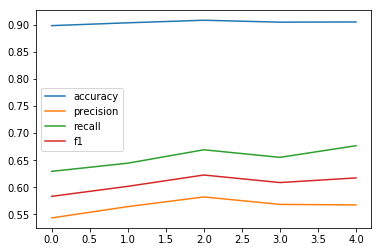

In [217]:
bdpp_logistic.k_fold_cross_val(fold=5, option='downsample', downratio=3)

### Upsampling

The shape of training set is:  (41188, 63) 

After upsampling, there are 29238 data entries labeled as yes.
 There are 29238 data entries labeled as no.


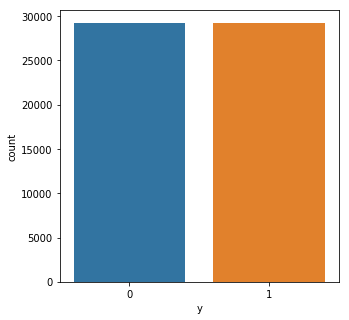

Accuracy Score: 0.8537266326778344
Precision Score: 0.427372836916623
Recall Score: 0.8782327586206896
f1 Score: 0.5749559082892416
confusion_matrix is: 
 [[6218 1092]
 [ 113  815]] 



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


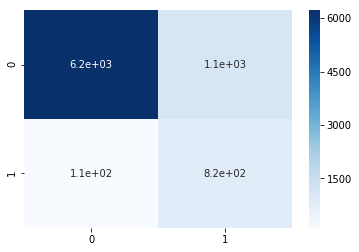

Accuracy Score: 0.8572469045884924
Precision Score: 0.4337606837606838
Recall Score: 0.875
f1 Score: 0.58
confusion_matrix is: 
 [[6250 1060]
 [ 116  812]] 



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


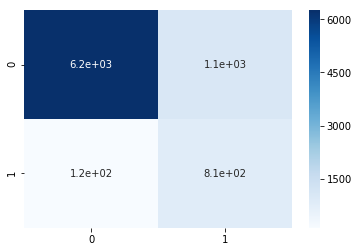

Accuracy Score: 0.8644088370963826
Precision Score: 0.4483888585472419
Recall Score: 0.884698275862069
f1 Score: 0.5951431678144254
confusion_matrix is: 
 [[6300 1010]
 [ 107  821]] 



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


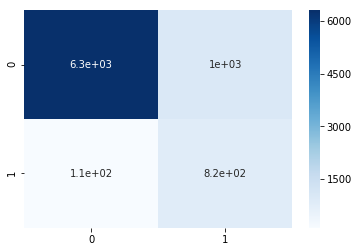

Accuracy Score: 0.8601432560398203
Precision Score: 0.4393939393939394
Recall Score: 0.875
f1 Score: 0.585014409221902
confusion_matrix is: 
 [[6273 1036]
 [ 116  812]] 



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


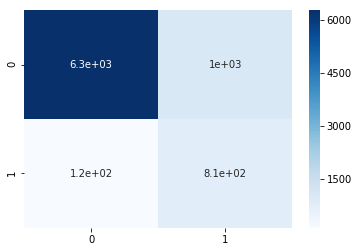

Accuracy Score: 0.8628141313585043
Precision Score: 0.4452871072589382
Recall Score: 0.8857758620689655
f1 Score: 0.5926459985580389
confusion_matrix is: 
 [[6285 1024]
 [ 106  822]] 



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


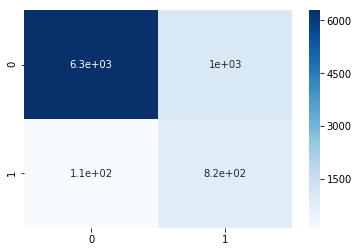

,accuracy,precision,recall,f1
0,0.853727,0.427373,0.878233,0.574956
1,0.857247,0.433761,0.875000,0.580000
2,0.864409,0.448389,0.884698,0.595143
3,0.860143,0.439394,0.875000,0.585014
4,0.862814,0.445287,0.885776,0.592646


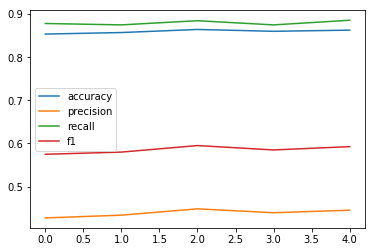

In [219]:
bdpp_logistic.k_fold_cross_val(fold=5, option='upsample')

The shape of training set is:  (41188, 63) 

After upsampling, there are 20466 data entries labeled as yes.
 There are 29238 data entries labeled as no.


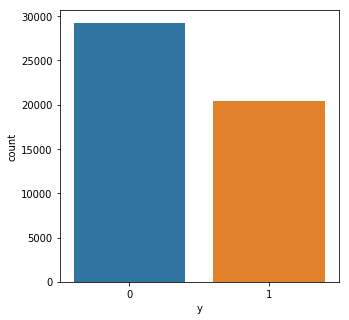

Accuracy Score: 0.8710852148579752
Precision Score: 0.4598802395209581
Recall Score: 0.8275862068965517
f1 Score: 0.5912240184757506
confusion_matrix is: 
 [[6408  902]
 [ 160  768]] 



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


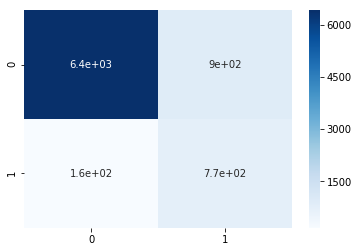

Accuracy Score: 0.8742413207089099
Precision Score: 0.4667487684729064
Recall Score: 0.8168103448275862
f1 Score: 0.5940438871473355
confusion_matrix is: 
 [[6444  866]
 [ 170  758]] 



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


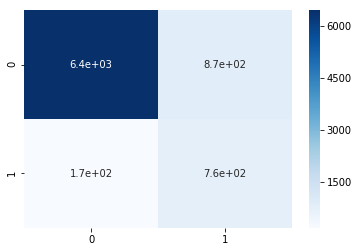

Accuracy Score: 0.8807963097839281
Precision Score: 0.48318804483188044
Recall Score: 0.8362068965517241
f1 Score: 0.6124704025256511
confusion_matrix is: 
 [[6480  830]
 [ 152  776]] 



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


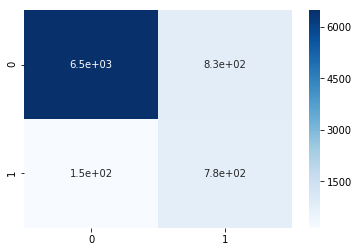

Accuracy Score: 0.8784751729998787
Precision Score: 0.4770872567482737
Recall Score: 0.8189655172413793
f1 Score: 0.6029353431178104
confusion_matrix is: 
 [[6476  833]
 [ 168  760]] 



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


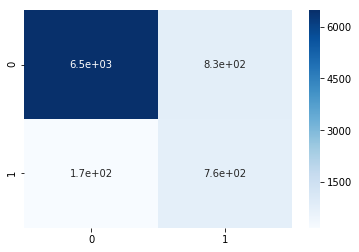

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Accuracy Score: 0.879446400388491
Precision Score: 0.47995064774830354
Recall Score: 0.8383620689655172
f1 Score: 0.6104354648881914
confusion_matrix is: 
 [[6466  843]
 [ 150  778]] 



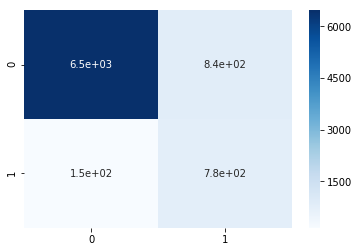

,accuracy,precision,recall,f1
0,0.871085,0.459880,0.827586,0.591224
1,0.874241,0.466749,0.816810,0.594044
2,0.880796,0.483188,0.836207,0.612470
3,0.878475,0.477087,0.818966,0.602935
4,0.879446,0.479951,0.838362,0.610435


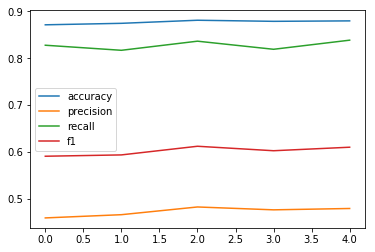

In [220]:
bdpp_logistic.k_fold_cross_val(fold=5, option='upsample', upratio=0.7)

The shape of training set is:  (41188, 63) 

After upsampling, there are 14619 data entries labeled as yes.
 There are 29238 data entries labeled as no.


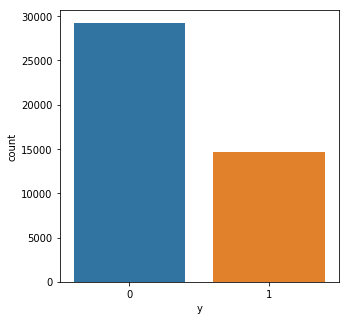

Accuracy Score: 0.8874726875455208
Precision Score: 0.5003573981415297
Recall Score: 0.7543103448275862
f1 Score: 0.6016330038676407
confusion_matrix is: 
 [[6611  699]
 [ 228  700]] 



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


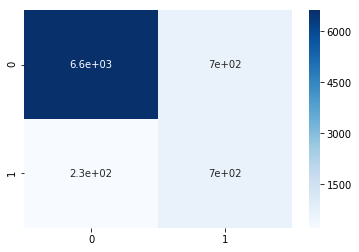

Accuracy Score: 0.8885651857246905
Precision Score: 0.5035971223021583
Recall Score: 0.7543103448275862
f1 Score: 0.6039689387402932
confusion_matrix is: 
 [[6620  690]
 [ 228  700]] 



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


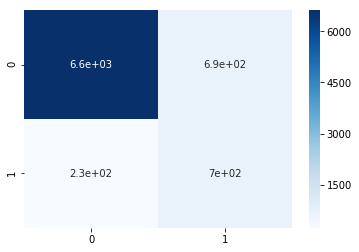

Accuracy Score: 0.8979121145909201
Precision Score: 0.5325355272999253
Recall Score: 0.7672413793103449
f1 Score: 0.6286975717439295
confusion_matrix is: 
 [[6685  625]
 [ 216  712]] 



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


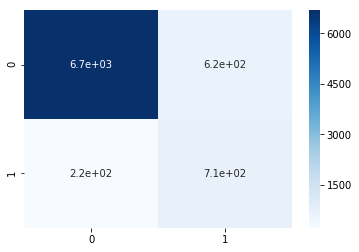

Accuracy Score: 0.8959572659949011
Precision Score: 0.5267924528301887
Recall Score: 0.7521551724137931
f1 Score: 0.619618286728806
confusion_matrix is: 
 [[6682  627]
 [ 230  698]] 



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


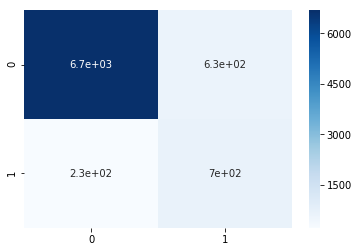

Accuracy Score: 0.8931649872526405
Precision Score: 0.5172661870503598
Recall Score: 0.7747844827586207
f1 Score: 0.6203623813632442
confusion_matrix is: 
 [[6638  671]
 [ 209  719]] 



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


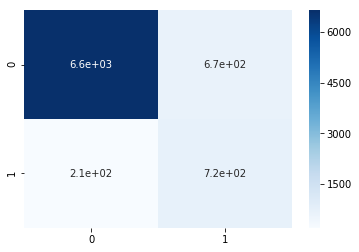

,accuracy,precision,recall,f1
0,0.887473,0.500357,0.754310,0.601633
1,0.888565,0.503597,0.754310,0.603969
2,0.897912,0.532536,0.767241,0.628698
3,0.895957,0.526792,0.752155,0.619618
4,0.893165,0.517266,0.774784,0.620362


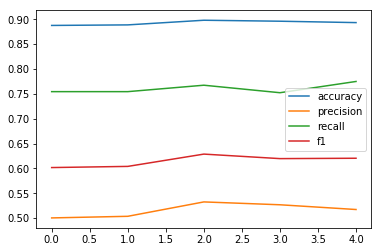

In [221]:
bdpp_logistic.k_fold_cross_val(fold=5, option='upsample', upratio=0.5)

The shape of training set is:  (41188, 63) 

After upsampling, there are 8771 data entries labeled as yes.
 There are 29238 data entries labeled as no.


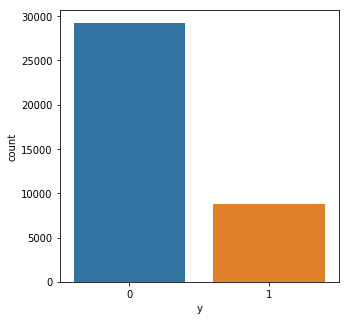

Accuracy Score: 0.902282107307599
Precision Score: 0.5602350636630754
Recall Score: 0.6163793103448276
f1 Score: 0.5869676757311442
confusion_matrix is: 
 [[6861  449]
 [ 356  572]] 



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


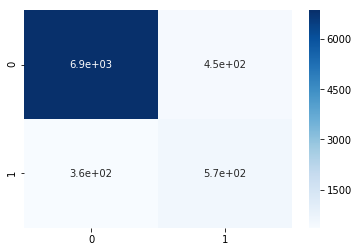

Accuracy Score: 0.9059237679048313
Precision Score: 0.5752212389380531
Recall Score: 0.6303879310344828
f1 Score: 0.6015424164524421
confusion_matrix is: 
 [[6878  432]
 [ 343  585]] 



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


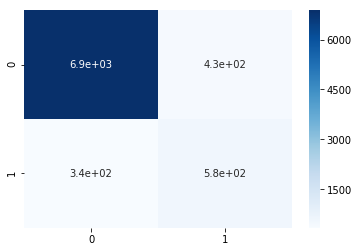

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Accuracy Score: 0.9110220927409566
Precision Score: 0.5972083748753739
Recall Score: 0.6454741379310345
f1 Score: 0.6204039357845677
confusion_matrix is: 
 [[6906  404]
 [ 329  599]] 



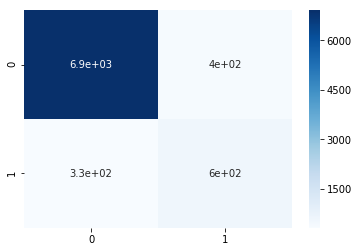

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Accuracy Score: 0.906640767269637
Precision Score: 0.578790882061447
Recall Score: 0.6293103448275862
f1 Score: 0.6029943211151265
confusion_matrix is: 
 [[6884  425]
 [ 344  584]] 



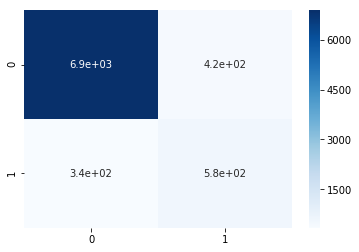

Accuracy Score: 0.9111326939419692
Precision Score: 0.5951456310679611
Recall Score: 0.6605603448275862
f1 Score: 0.6261491317671093
confusion_matrix is: 
 [[6892  417]
 [ 315  613]] 



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


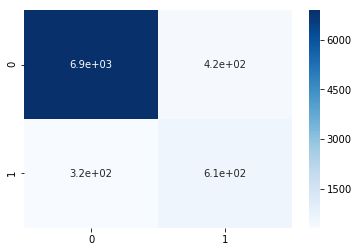

,accuracy,precision,recall,f1
0,0.902282,0.560235,0.616379,0.586968
1,0.905924,0.575221,0.630388,0.601542
2,0.911022,0.597208,0.645474,0.620404
3,0.906641,0.578791,0.629310,0.602994
4,0.911133,0.595146,0.660560,0.626149


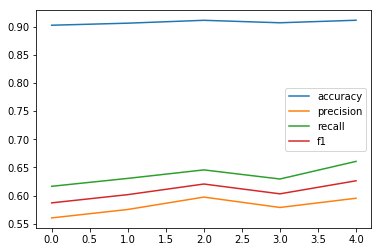

In [222]:
bdpp_logistic.k_fold_cross_val(fold=5, option='upsample', upratio=0.3)

After re-sampling, the FN value is reduced, however the FP value gets higher. All in all, the f1 score is improved, thus the performance is better because f1 score considers influence from both FN and FP value.

## Task 3

Feature Selection

- Please summary the reason why we perform feature selection? 
- Please perform feature selection based on the correlation results in Assignment 1 (using
chi-square for categorical data and mutual information for numerical data).
- Generate partial datasets by only using top k (k =1, 3, 5) most correlated
categorical features and numerical features for model training (i.e., k categorical
features + k numerical features). 
Follow the setup in Task 1 to compare the
performance of partial datasets with the original dataset.

- __Please summary the reason why we perform feature selection__

Because the feature set has high dimensionality, hence choosing the most important features from the original set is necessary to prevent overfitting with too many features and reduce the time complexity of the training phase.

### Top K = 1

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The shape of training set is:  (41188, 4) 

Accuracy Score: 0.8883224083515416
Precision Score: 0.5178571428571429
Recall Score: 0.125
f1 Score: 0.2013888888888889
confusion_matrix is: 
 [[7202  108]
 [ 812  116]] 



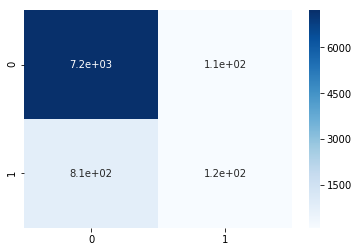

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy Score: 0.8936635105608157
Precision Score: 0.604
Recall Score: 0.1627155172413793
f1 Score: 0.2563667232597623
confusion_matrix is: 
 [[7211   99]
 [ 777  151]] 



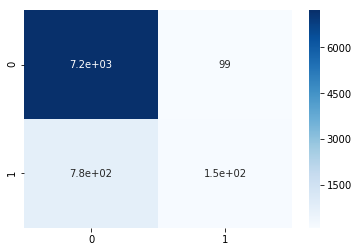

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy Score: 0.8945132313668366
Precision Score: 0.6334841628959276
Recall Score: 0.15086206896551724
f1 Score: 0.24369016536118362
confusion_matrix is: 
 [[7229   81]
 [ 788  140]] 



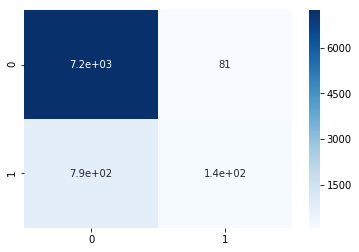

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy Score: 0.8951074420298653
Precision Score: 0.6454545454545455
Recall Score: 0.15301724137931033
f1 Score: 0.24738675958188155
confusion_matrix is: 
 [[7231   78]
 [ 786  142]] 



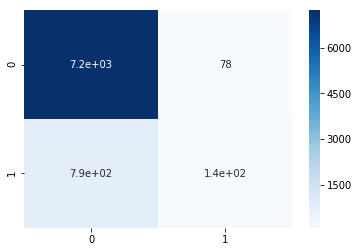

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy Score: 0.8935291975233701
Precision Score: 0.6049382716049383
Recall Score: 0.1584051724137931
f1 Score: 0.25106746370623395
confusion_matrix is: 
 [[7213   96]
 [ 781  147]] 



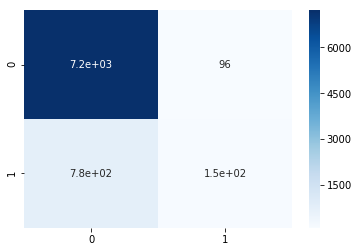

,accuracy,precision,recall,f1
0,0.888322,0.517857,0.125000,0.201389
1,0.893664,0.604000,0.162716,0.256367
2,0.894513,0.633484,0.150862,0.243690
3,0.895107,0.645455,0.153017,0.247387
4,0.893529,0.604938,0.158405,0.251067


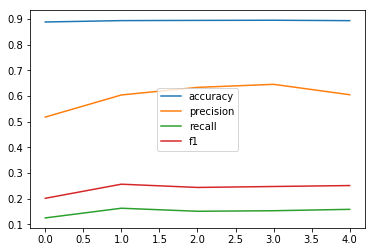

In [223]:
bdpp_logistic = BankDataProcessPipeline(bank, classifier)
bdpp_logistic.k_fold_cross_val(fold=5, feature_engineered=True, topK=1)

### Top K = 3

The shape of training set is:  (41188, 16) 



/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy Score: 0.8949987861131342
Precision Score: 0.584
Recall Score: 0.23599137931034483
f1 Score: 0.33614735226400616
confusion_matrix is: 
 [[7154  156]
 [ 709  219]] 



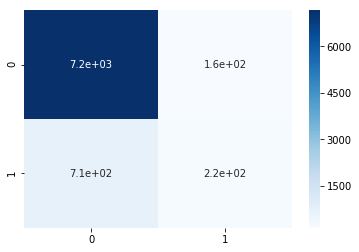

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy Score: 0.9002184996358339
Precision Score: 0.6417112299465241
Recall Score: 0.25862068965517243
f1 Score: 0.3686635944700461
confusion_matrix is: 
 [[7176  134]
 [ 688  240]] 



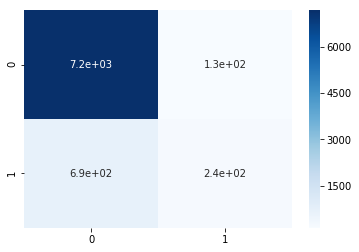

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy Score: 0.9004612770089827
Precision Score: 0.6560693641618497
Recall Score: 0.24461206896551724
f1 Score: 0.3563579277864992
confusion_matrix is: 
 [[7191  119]
 [ 701  227]] 



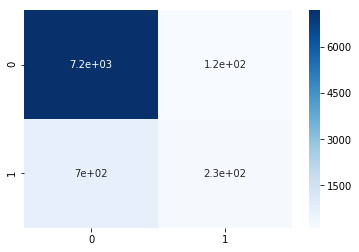

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy Score: 0.9015418234794221
Precision Score: 0.6481012658227848
Recall Score: 0.27586206896551724
f1 Score: 0.3869992441421013
confusion_matrix is: 
 [[7170  139]
 [ 672  256]] 



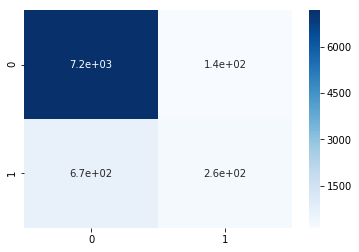

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy Score: 0.9022702440208814
Precision Score: 0.660574412532637
Recall Score: 0.27262931034482757
f1 Score: 0.38596491228070173
confusion_matrix is: 
 [[7179  130]
 [ 675  253]] 



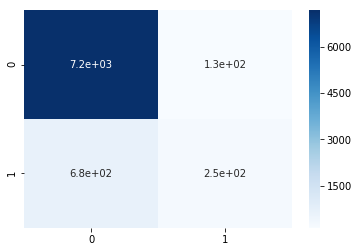

,accuracy,precision,recall,f1
0,0.894999,0.584000,0.235991,0.336147
1,0.900218,0.641711,0.258621,0.368664
2,0.900461,0.656069,0.244612,0.356358
3,0.901542,0.648101,0.275862,0.386999
4,0.902270,0.660574,0.272629,0.385965


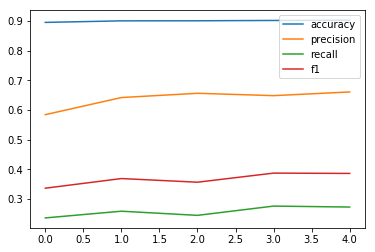

In [224]:
bdpp_logistic.k_fold_cross_val(fold=5, feature_engineered=True, topK=3)

### Top K = 5

The shape of training set is:  (41188, 33) 



/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy Score: 0.9031318281136198
Precision Score: 0.626953125
Recall Score: 0.3459051724137931
f1 Score: 0.4458333333333333
confusion_matrix is: 
 [[7119  191]
 [ 607  321]] 



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


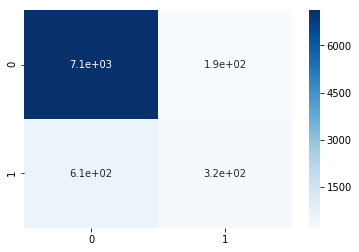

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy Score: 0.9098082058752124
Precision Score: 0.6789168278529981
Recall Score: 0.37823275862068967
f1 Score: 0.4858131487889274
confusion_matrix is: 
 [[7144  166]
 [ 577  351]] 



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


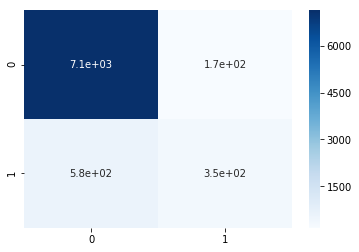

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy Score: 0.9106579266812334
Precision Score: 0.6951219512195121
Recall Score: 0.36853448275862066
f1 Score: 0.48169014084507034
confusion_matrix is: 
 [[7160  150]
 [ 586  342]] 



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


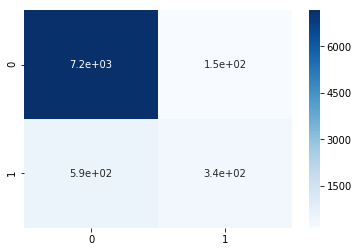

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy Score: 0.909554449435474
Precision Score: 0.6742857142857143
Recall Score: 0.38146551724137934
f1 Score: 0.4872677219545767
confusion_matrix is: 
 [[7138  171]
 [ 574  354]] 



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


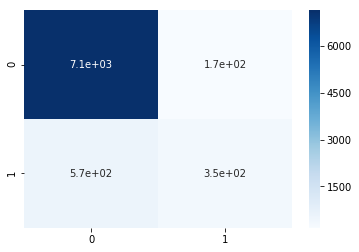

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy Score: 0.913317955566347
Precision Score: 0.7131474103585658
Recall Score: 0.3857758620689655
f1 Score: 0.5006993006993007
confusion_matrix is: 
 [[7165  144]
 [ 570  358]] 



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


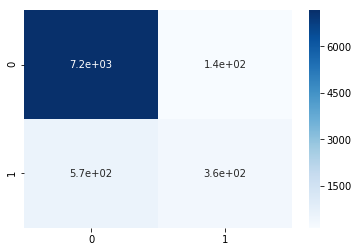

,accuracy,precision,recall,f1
0,0.903132,0.626953,0.345905,0.445833
1,0.909808,0.678917,0.378233,0.485813
2,0.910658,0.695122,0.368534,0.481690
3,0.909554,0.674286,0.381466,0.487268
4,0.913318,0.713147,0.385776,0.500699


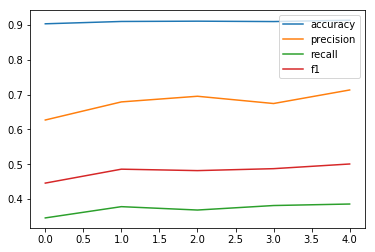

In [225]:
bdpp_logistic.k_fold_cross_val(fold=5, feature_engineered=True, topK=5)

when top K = 5, the performance metrics is quite similar to the original dataset; if top K is smaller than 5, the performance is not as good.

## Task 4

Model Comparison


In addition to logistic regression classification, Decision tree and Multilayer
perceptron neural network are also widely used for classification. Please
follow the setup in Task 1 to compare the performance of these two models with
Logistic Regression Model on both balanced and imbalanced datasets.


In [233]:
lr = LogisticRegression(random_state=SEED, solver='lbfgs')
dt = DecisionTreeClassifier(criterion = 'entropy',
                            random_state = SEED)
mlp = MLPClassifier(random_state = SEED)

### Unbalanced Dataset

#### LogisticRegression

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The shape of training set is:  (41188, 63) 

Accuracy Score: 0.9037387715464918
Precision Score: 0.623400365630713
Recall Score: 0.36745689655172414
f1 Score: 0.4623728813559322
confusion_matrix is: 
 [[7104  206]
 [ 587  341]] 



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


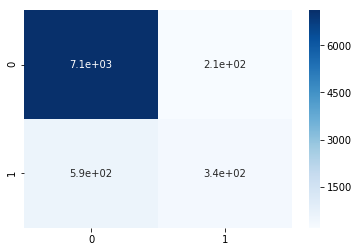

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy Score: 0.9109007040543822
Precision Score: 0.677007299270073
Recall Score: 0.39978448275862066
f1 Score: 0.502710027100271
confusion_matrix is: 
 [[7133  177]
 [ 557  371]] 



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


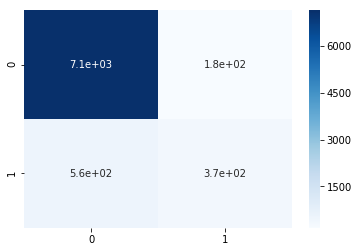

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Accuracy Score: 0.9102937606215101
Precision Score: 0.68
Recall Score: 0.38469827586206895
f1 Score: 0.49139710942876796
confusion_matrix is: 
 [[7142  168]
 [ 571  357]] 



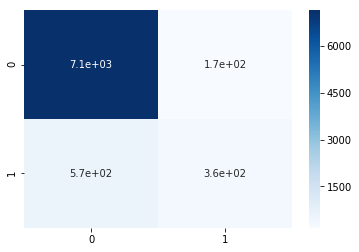

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy Score: 0.9101614665533568
Precision Score: 0.6690647482014388
Recall Score: 0.40086206896551724
f1 Score: 0.5013477088948787
confusion_matrix is: 
 [[7125  184]
 [ 556  372]] 



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


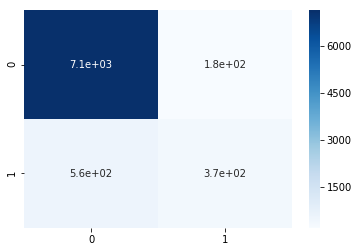

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy Score: 0.9147747966492655
Precision Score: 0.7092592592592593
Recall Score: 0.41271551724137934
f1 Score: 0.5217983651226158
confusion_matrix is: 
 [[7152  157]
 [ 545  383]] 



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


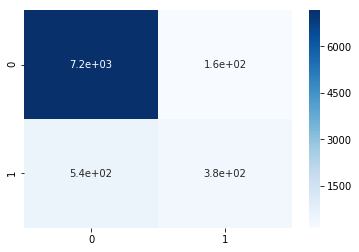

,accuracy,precision,recall,f1
0,0.903739,0.623400,0.367457,0.462373
1,0.910901,0.677007,0.399784,0.502710
2,0.910294,0.680000,0.384698,0.491397
3,0.910161,0.669065,0.400862,0.501348
4,0.914775,0.709259,0.412716,0.521798


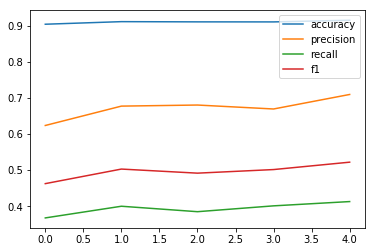

In [228]:
bdpp_logistic = BankDataProcessPipeline(df=bank, classifier=lr)
bdpp_logistic.k_fold_cross_val(fold=5)

#### DecisionTree

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


The shape of training set is:  (41188, 63) 

Accuracy Score: 0.8827385287691187
Precision Score: 0.47925764192139736
Recall Score: 0.4730603448275862
f1 Score: 0.4761388286334056
confusion_matrix is: 
 [[6833  477]
 [ 489  439]] 



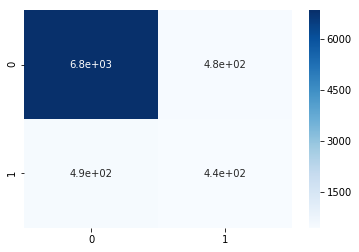

Accuracy Score: 0.8907501820830298
Precision Score: 0.5157657657657657
Recall Score: 0.49353448275862066
f1 Score: 0.5044052863436123
confusion_matrix is: 
 [[6880  430]
 [ 470  458]] 



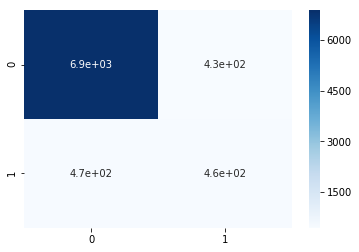

Accuracy Score: 0.8906287933964554
Precision Score: 0.5134328358208955
Recall Score: 0.5560344827586207
f1 Score: 0.5338851526125195
confusion_matrix is: 
 [[6821  489]
 [ 412  516]] 



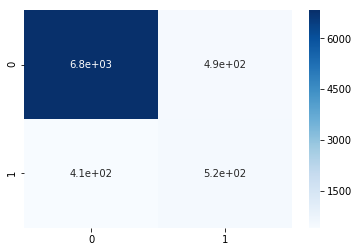

Accuracy Score: 0.8879446400388491
Precision Score: 0.5026511134676565
Recall Score: 0.5107758620689655
f1 Score: 0.5066809192944949
confusion_matrix is: 
 [[6840  469]
 [ 454  474]] 



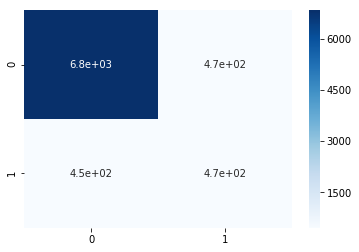

Accuracy Score: 0.8921937598640282
Precision Score: 0.5224719101123596
Recall Score: 0.5010775862068966
f1 Score: 0.5115511551155116
confusion_matrix is: 
 [[6884  425]
 [ 463  465]] 



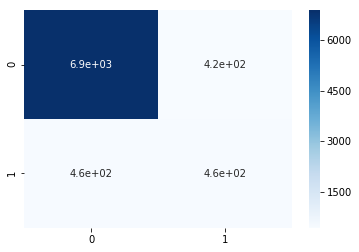

,accuracy,precision,recall,f1
0,0.882739,0.479258,0.473060,0.476139
1,0.890750,0.515766,0.493534,0.504405
2,0.890629,0.513433,0.556034,0.533885
3,0.887945,0.502651,0.510776,0.506681
4,0.892194,0.522472,0.501078,0.511551


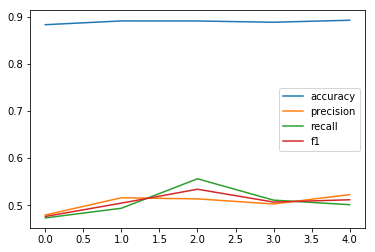

In [229]:
bdpp_dt = BankDataProcessPipeline(df=bank, classifier=dt)
bdpp_dt.k_fold_cross_val(fold=5)

#### MultilayerPerceptron

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The shape of training set is:  (41188, 63) 

Accuracy Score: 0.8986404467103666
Precision Score: 0.5551601423487544
Recall Score: 0.5043103448275862
f1 Score: 0.528514963297572
confusion_matrix is: 
 [[6935  375]
 [ 460  468]] 



/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


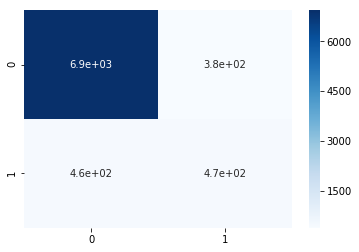

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy Score: 0.9037387715464918
Precision Score: 0.5884665792922673
Recall Score: 0.4838362068965517
f1 Score: 0.5310467179183914
confusion_matrix is: 
 [[6996  314]
 [ 479  449]] 



/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


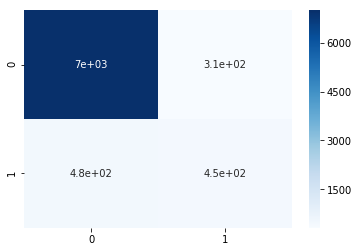

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Accuracy Score: 0.9036173828599174
Precision Score: 0.5907859078590786
Recall Score: 0.4698275862068966
f1 Score: 0.5234093637454982
confusion_matrix is: 
 [[7008  302]
 [ 492  436]] 



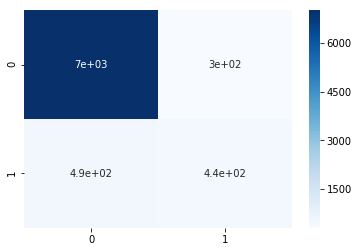

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy Score: 0.9042126987981061
Precision Score: 0.5783540022547914
Recall Score: 0.552801724137931
f1 Score: 0.565289256198347
confusion_matrix is: 
 [[6935  374]
 [ 415  513]] 



/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


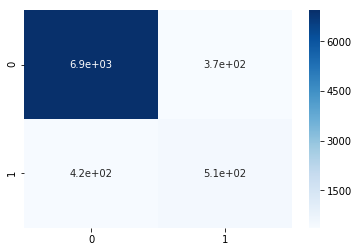

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy Score: 0.9045769090688357
Precision Score: 0.5801354401805869
Recall Score: 0.5538793103448276
f1 Score: 0.5667034178610805
confusion_matrix is: 
 [[6937  372]
 [ 414  514]] 



/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


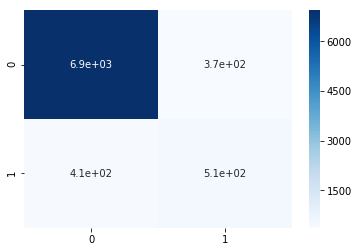

,accuracy,precision,recall,f1
0,0.898640,0.555160,0.504310,0.528515
1,0.903739,0.588467,0.483836,0.531047
2,0.903617,0.590786,0.469828,0.523409
3,0.904213,0.578354,0.552802,0.565289
4,0.904577,0.580135,0.553879,0.566703


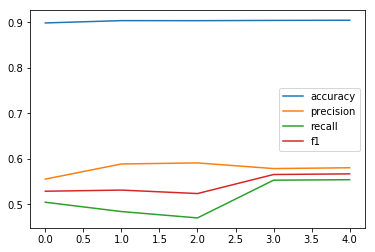

In [234]:
bdpp_mlp = BankDataProcessPipeline(df=bank, classifier=mlp)
bdpp_mlp.k_fold_cross_val(fold=5)

The performances of Logistic Regression and Decision Tree are similar, and the performance of MLP appears to be the best because it outputs the highest f1 score.

### Balanced Dataset

#### LogisticRegression

In [235]:
bdpp_logistic = BankDataProcessPipeline(df=bank, classifier=lr)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


##### Downsample

The shape of training set is:  (41188, 63) 

After downsampling, there are 3712 data entries labeled as yes.
 There are 3712 data entries labeled as no.


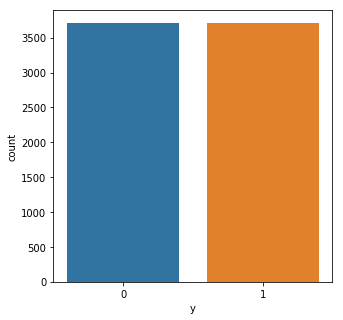

Accuracy Score: 0.8561544064093226
Precision Score: 0.4303523035230352
Recall Score: 0.8556034482758621
f1 Score: 0.572664983772088
confusion_matrix is: 
 [[6259 1051]
 [ 134  794]] 



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


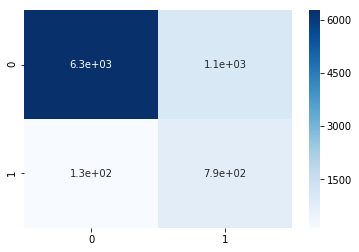

Accuracy Score: 0.8580966253945133
Precision Score: 0.4340448823207444
Recall Score: 0.8545258620689655
f1 Score: 0.5756805807622505
confusion_matrix is: 
 [[6276 1034]
 [ 135  793]] 



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


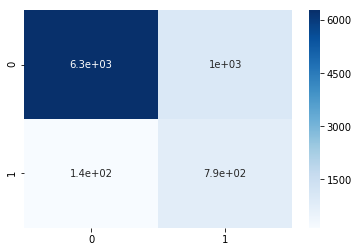

Accuracy Score: 0.8648943918426802
Precision Score: 0.4489795918367347
Recall Score: 0.8771551724137931
f1 Score: 0.5939438161255016
confusion_matrix is: 
 [[6311  999]
 [ 114  814]] 



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


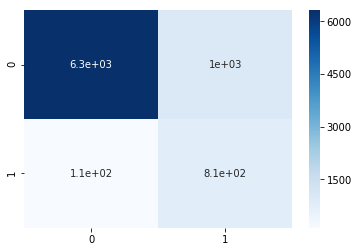

Accuracy Score: 0.8566225567561006
Precision Score: 0.4312873438348723
Recall Score: 0.8556034482758621
f1 Score: 0.5734922354640665
confusion_matrix is: 
 [[6262 1047]
 [ 134  794]] 



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


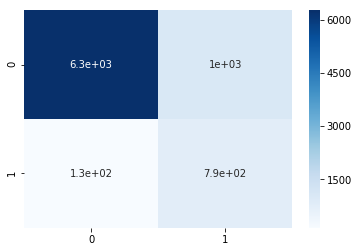

Accuracy Score: 0.8606288697341266
Precision Score: 0.4403470715835141
Recall Score: 0.875
f1 Score: 0.5858585858585859
confusion_matrix is: 
 [[6277 1032]
 [ 116  812]] 



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


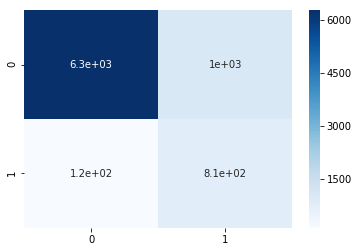

,accuracy,precision,recall,f1
0,0.856154,0.430352,0.855603,0.572665
1,0.858097,0.434045,0.854526,0.575681
2,0.864894,0.448980,0.877155,0.593944
3,0.856623,0.431287,0.855603,0.573492
4,0.860629,0.440347,0.875000,0.585859


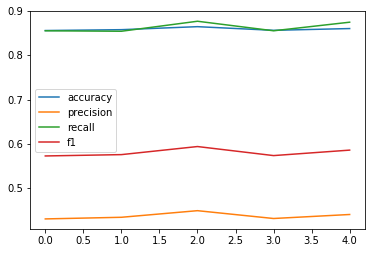

In [236]:
bdpp_logistic.k_fold_cross_val(fold=5, option='downsample')

##### Upsample

The shape of training set is:  (41188, 63) 

After upsampling, there are 29238 data entries labeled as yes.
 There are 29238 data entries labeled as no.


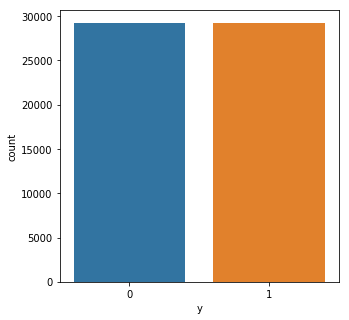

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Accuracy Score: 0.8537266326778344
Precision Score: 0.427372836916623
Recall Score: 0.8782327586206896
f1 Score: 0.5749559082892416
confusion_matrix is: 
 [[6218 1092]
 [ 113  815]] 



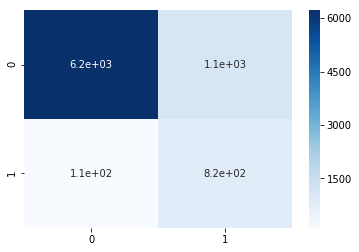

Accuracy Score: 0.8572469045884924
Precision Score: 0.4337606837606838
Recall Score: 0.875
f1 Score: 0.58
confusion_matrix is: 
 [[6250 1060]
 [ 116  812]] 



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


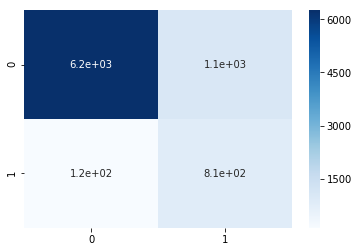

Accuracy Score: 0.8644088370963826
Precision Score: 0.4483888585472419
Recall Score: 0.884698275862069
f1 Score: 0.5951431678144254
confusion_matrix is: 
 [[6300 1010]
 [ 107  821]] 



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


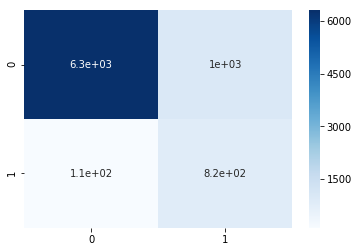

Accuracy Score: 0.8601432560398203
Precision Score: 0.4393939393939394
Recall Score: 0.875
f1 Score: 0.585014409221902
confusion_matrix is: 
 [[6273 1036]
 [ 116  812]] 



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


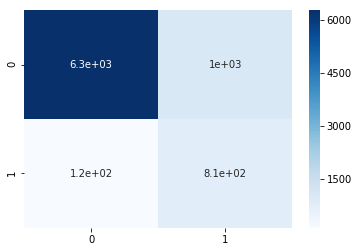

Accuracy Score: 0.8628141313585043
Precision Score: 0.4452871072589382
Recall Score: 0.8857758620689655
f1 Score: 0.5926459985580389
confusion_matrix is: 
 [[6285 1024]
 [ 106  822]] 



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


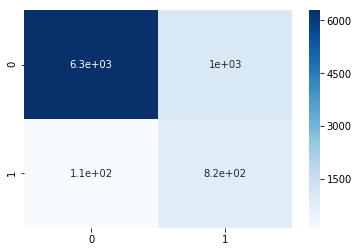

,accuracy,precision,recall,f1
0,0.853727,0.427373,0.878233,0.574956
1,0.857247,0.433761,0.875000,0.580000
2,0.864409,0.448389,0.884698,0.595143
3,0.860143,0.439394,0.875000,0.585014
4,0.862814,0.445287,0.885776,0.592646


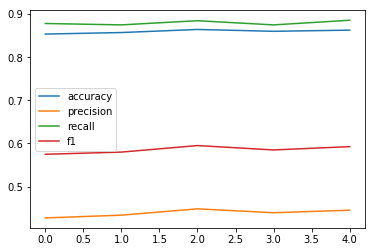

In [237]:
bdpp_logistic.k_fold_cross_val(fold=5, option='upsample')

#### DecisionTree

In [238]:
bdpp_dt = BankDataProcessPipeline(df=bank, classifier=dt)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


##### Downsample

The shape of training set is:  (41188, 63) 

After downsampling, there are 3712 data entries labeled as yes.
 There are 3712 data entries labeled as no.


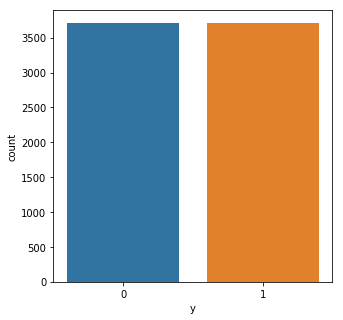

Accuracy Score: 0.8327263899004613
Precision Score: 0.3859026369168357
Recall Score: 0.8200431034482759
f1 Score: 0.5248275862068964
confusion_matrix is: 
 [[6099 1211]
 [ 167  761]] 



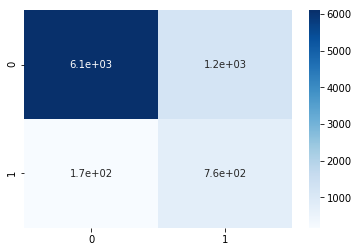

Accuracy Score: 0.8415877640203933
Precision Score: 0.4014636696288552
Recall Score: 0.8275862068965517
f1 Score: 0.5406546990496305
confusion_matrix is: 
 [[6165 1145]
 [ 160  768]] 



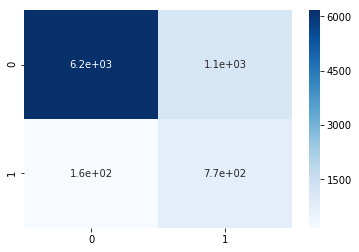

Accuracy Score: 0.8449866472444768
Precision Score: 0.40887728459530026
Recall Score: 0.84375
f1 Score: 0.5508265916285614
confusion_matrix is: 
 [[6178 1132]
 [ 145  783]] 



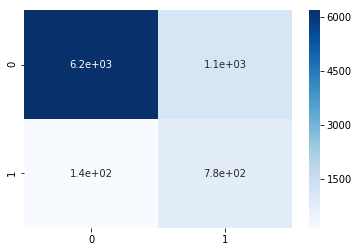

Accuracy Score: 0.8344057302415928
Precision Score: 0.3896761133603239
Recall Score: 0.8297413793103449
f1 Score: 0.5303030303030304
confusion_matrix is: 
 [[6103 1206]
 [ 158  770]] 



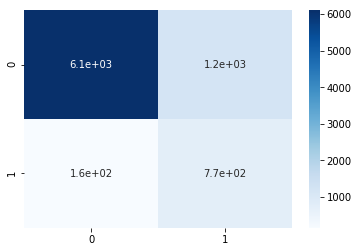

Accuracy Score: 0.8464246691756707
Precision Score: 0.41117554032683185
Recall Score: 0.8405172413793104
f1 Score: 0.552212389380531
confusion_matrix is: 
 [[6192 1117]
 [ 148  780]] 



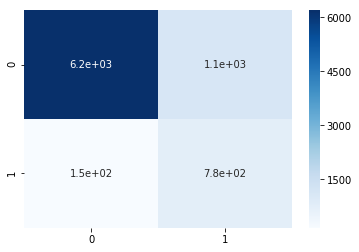

,accuracy,precision,recall,f1
0,0.832726,0.385903,0.820043,0.524828
1,0.841588,0.401464,0.827586,0.540655
2,0.844987,0.408877,0.843750,0.550827
3,0.834406,0.389676,0.829741,0.530303
4,0.846425,0.411176,0.840517,0.552212


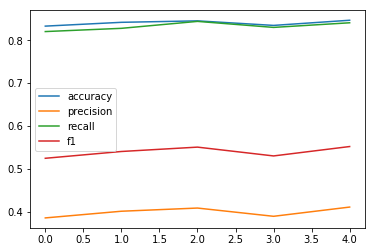

In [239]:
bdpp_dt.k_fold_cross_val(fold=5, option='downsample')

##### Upsample

The shape of training set is:  (41188, 63) 

After upsampling, there are 29238 data entries labeled as yes.
 There are 29238 data entries labeled as no.


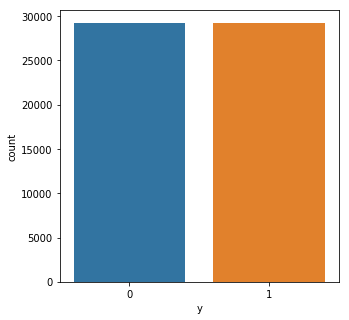

Accuracy Score: 0.8897790725904345
Precision Score: 0.5112359550561798
Recall Score: 0.49030172413793105
f1 Score: 0.5005500550055006
confusion_matrix is: 
 [[6875  435]
 [ 473  455]] 



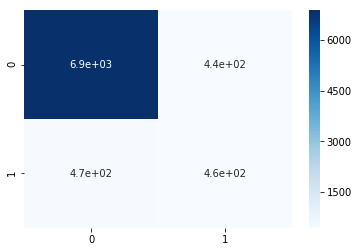

Accuracy Score: 0.8895362952172857
Precision Score: 0.5097402597402597
Recall Score: 0.5075431034482759
f1 Score: 0.5086393088552916
confusion_matrix is: 
 [[6857  453]
 [ 457  471]] 



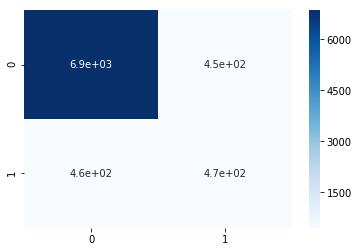

Accuracy Score: 0.8939062879339645
Precision Score: 0.5277207392197125
Recall Score: 0.5538793103448276
f1 Score: 0.5404837013669822
confusion_matrix is: 
 [[6850  460]
 [ 414  514]] 



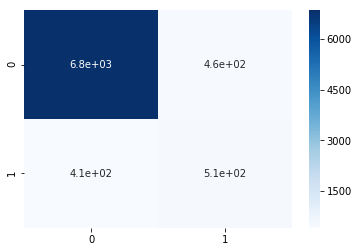

Accuracy Score: 0.8904941119339566
Precision Score: 0.5142543859649122
Recall Score: 0.5053879310344828
f1 Score: 0.5097826086956523
confusion_matrix is: 
 [[6866  443]
 [ 459  469]] 



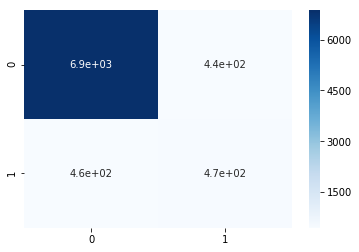

Accuracy Score: 0.8926793735583344
Precision Score: 0.5247747747747747
Recall Score: 0.5021551724137931
f1 Score: 0.513215859030837
confusion_matrix is: 
 [[6887  422]
 [ 462  466]] 



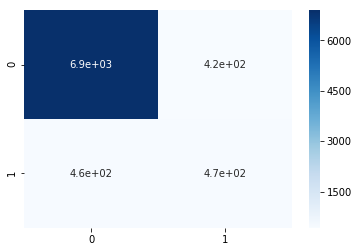

,accuracy,precision,recall,f1
0,0.889779,0.511236,0.490302,0.500550
1,0.889536,0.509740,0.507543,0.508639
2,0.893906,0.527721,0.553879,0.540484
3,0.890494,0.514254,0.505388,0.509783
4,0.892679,0.524775,0.502155,0.513216


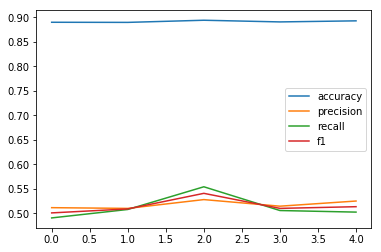

In [240]:
bdpp_dt.k_fold_cross_val(fold=5, option='upsample')

#### MultilayerPerceptron

In [241]:
bdpp_mlp = BankDataProcessPipeline(df=bank, classifier=mlp)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


##### Downsample

The shape of training set is:  (41188, 63) 

After downsampling, there are 3712 data entries labeled as yes.
 There are 3712 data entries labeled as no.


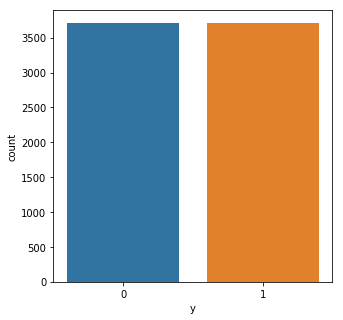

Accuracy Score: 0.8567613498421947
Precision Score: 0.43061674008810574
Recall Score: 0.8426724137931034
f1 Score: 0.5699708454810496
confusion_matrix is: 
 [[6276 1034]
 [ 146  782]] 



/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


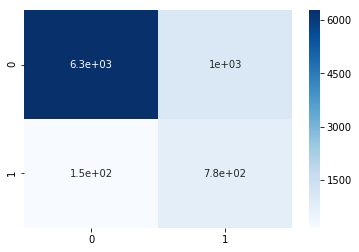

Accuracy Score: 0.8696285506190823
Precision Score: 0.45602409638554214
Recall Score: 0.8157327586206896
f1 Score: 0.5850077279752705
confusion_matrix is: 
 [[6407  903]
 [ 171  757]] 



/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


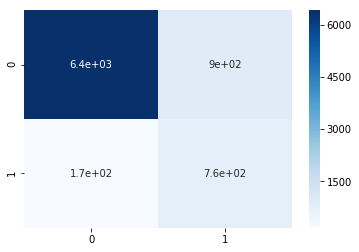

Accuracy Score: 0.8766690944403982
Precision Score: 0.4732685297691373
Recall Score: 0.8394396551724138
f1 Score: 0.6052836052836053
confusion_matrix is: 
 [[6443  867]
 [ 149  779]] 



/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


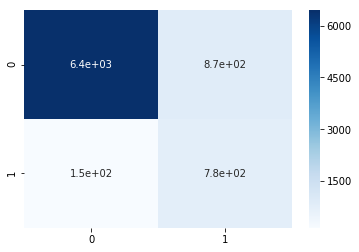

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Accuracy Score: 0.8595362389219376
Precision Score: 0.4357823892316321
Recall Score: 0.8372844827586207
f1 Score: 0.5732202139431944
confusion_matrix is: 
 [[6303 1006]
 [ 151  777]] 



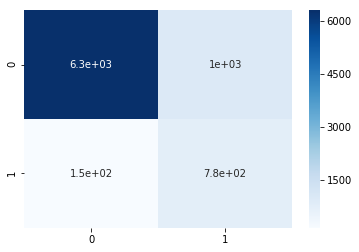

Accuracy Score: 0.8635425518999635
Precision Score: 0.44633077765607887
Recall Score: 0.8782327586206896
f1 Score: 0.5918663761801017
confusion_matrix is: 
 [[6298 1011]
 [ 113  815]] 



/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


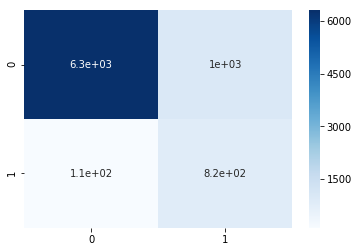

,accuracy,precision,recall,f1
0,0.856761,0.430617,0.842672,0.569971
1,0.869629,0.456024,0.815733,0.585008
2,0.876669,0.473269,0.839440,0.605284
3,0.859536,0.435782,0.837284,0.573220
4,0.863543,0.446331,0.878233,0.591866


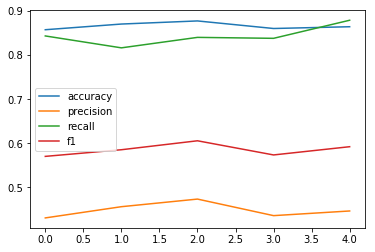

In [242]:
bdpp_mlp.k_fold_cross_val(fold=5, option='downsample')

##### Upsample

The shape of training set is:  (41188, 63) 

After upsampling, there are 29238 data entries labeled as yes.
 There are 29238 data entries labeled as no.


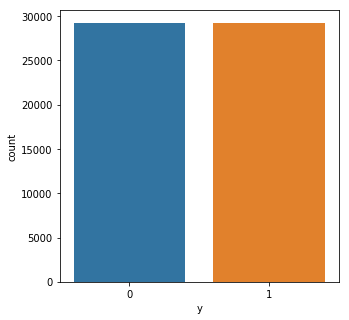

Accuracy Score: 0.878975479485312
Precision Score: 0.4753395282344532
Recall Score: 0.7165948275862069
f1 Score: 0.5715513536742587
confusion_matrix is: 
 [[6576  734]
 [ 263  665]] 



/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


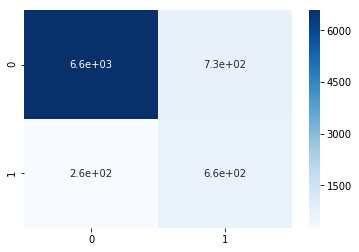

Accuracy Score: 0.8844379703811605
Precision Score: 0.49129172714078373
Recall Score: 0.7295258620689655
f1 Score: 0.5871639202081526
confusion_matrix is: 
 [[6609  701]
 [ 251  677]] 



/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


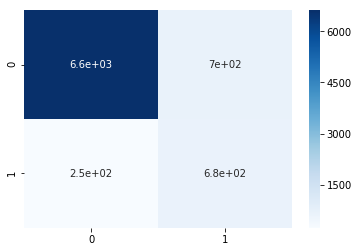

Accuracy Score: 0.8822529740228211
Precision Score: 0.4857336956521739
Recall Score: 0.7704741379310345
f1 Score: 0.5958333333333333
confusion_matrix is: 
 [[6553  757]
 [ 213  715]] 



/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


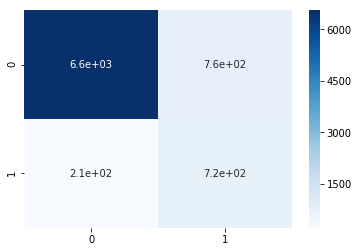

Accuracy Score: 0.866092023795071
Precision Score: 0.44680851063829785
Recall Score: 0.7920258620689655
f1 Score: 0.5713175281772249
confusion_matrix is: 
 [[6399  910]
 [ 193  735]] 



/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


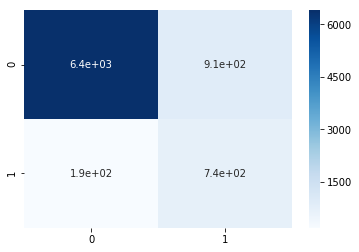

Accuracy Score: 0.8856379749908947
Precision Score: 0.4948071216617211
Recall Score: 0.71875
f1 Score: 0.5861159929701231
confusion_matrix is: 
 [[6628  681]
 [ 261  667]] 



/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


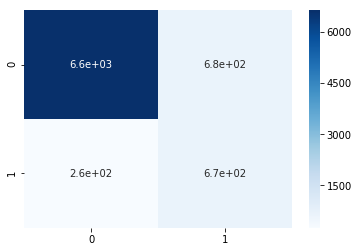

,accuracy,precision,recall,f1
0,0.878975,0.475340,0.716595,0.571551
1,0.884438,0.491292,0.729526,0.587164
2,0.882253,0.485734,0.770474,0.595833
3,0.866092,0.446809,0.792026,0.571318
4,0.885638,0.494807,0.718750,0.586116


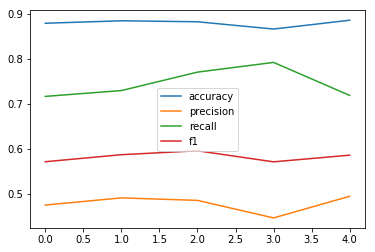

In [243]:
bdpp_mlp.k_fold_cross_val(fold=5, option='upsample')

After re-sampling, the performances of Logistic Regression and MLP are similar, and the performance of Decision Tree appears to be the worst among the three because it outputs the lowest f1 score.